In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import ode
from matplotlib.colors import to_rgba,to_rgb

In [2]:
def my_pinv(X,rank):
    U, Σ, Vh = np.linalg.svd(X,full_matrices=False)
    print(Σ)
    Σ[rank:] = 0.0
    return Vh.T.conj().dot(np.linalg.pinv(np.diag(Σ))).dot(U.T.conj())

In [3]:
# Define Lorenz system
def f(t,state,par):
    σ,ρ,β = par
    x,y,z = state
    return np.array([σ*(y-x),
                  x*(ρ-z)-y,
                  x*y-β*z])

# Jacobian
def Df(t,state,par):
    σ,ρ,β = par
    x,y,z = state
    print(np.array([[-σ,σ,0],[ρ-z,-1,-x],[y,x,-β]]))
    return np.array([[-σ,σ,0],[ρ-z,-1,-x],[y,x,-β]])

step = 0.001
n_iter = 1200*4
#t = np.arange(0, 100, step)
t_vals = np.arange(0,n_iter*step,step)
Y = np.empty((3, t_vals.size))
#Y[:,0] = np.array([1.508870,-1.531271,25.46091])

Y[:,0] = np.array([6.7673,6.1253,25.8706])
#Y[:,0] = np.array([6*np.sqrt(2)+0.01,6*np.sqrt(2),27])
σ,ρ,β = 10,28,8.0/3.0

#state = odeint(f, y0, t, args=(σ,ρ,β))

r = ode(f).set_integrator('dopri5')
r.set_initial_value(Y[:,0], t_vals[0])
r.set_f_params((σ,ρ,β))

for i,t in enumerate(t_vals):
    if i == 0:
        continue
    r.integrate(t)
    Y[:,i] = r.y
    
noise_level = 0.0
Y += np.random.randn(*Y.shape)*noise_level

In [4]:
num_eigenvals = 3
# Normal Solution (related to exactDMD)
normal_alg = {}
normal_alg['A'] = Y[:,1:].dot(my_pinv(Y[:,:-1],num_eigenvals))
normal_alg['label'] = 'Normal'
normal_alg['eig_vals'] = np.linalg.eig(normal_alg['A'])[0]
normal_alg['one_step_reco'] = normal_alg['A'].dot(Y[:,:-1])
normal_alg['reco'] = np.zeros(Y.shape)

# Centered solution (related to centering your data)
centered_num_eigenvals = 3
centered_alg = {}
μ1 = Y[:,:-1].mean(axis=1)
μ2 = Y[:,1:].mean(axis=1)
centered_alg['A'] = (Y[:,1:] - μ2[:,np.newaxis]).dot(my_pinv(Y[:,:-1] - μ1[:,np.newaxis],centered_num_eigenvals))
centered_alg['b'] = μ2 - centered_alg['A'].dot(μ1)
centered_alg['label'] = 'Centered'
centered_alg['eig_vals'] = np.linalg.eig(centered_alg['A'])[0]
centered_alg['one_step_reco'] = centered_alg['A'].dot(Y[:,:-1]) + centered_alg['b'][:,np.newaxis]
centered_alg['reco'] = np.zeros(Y.shape)

normal_alg['reco'][:,0] = Y[:,0] 
for _i in range(1,Y.shape[-1]):
    normal_alg['reco'][:,_i] = normal_alg['A'].dot(normal_alg['reco'][:,_i-1])
    
centered_alg['reco'][:,0] = Y[:,0] 
for _i in range(1,Y.shape[-1]):
    centered_alg['reco'][:,_i] = centered_alg['A'].dot(centered_alg['reco'][:,_i-1]) + centered_alg['b']

[2016.40415688  186.26033959   42.75673498]
[232.54413169 186.25479047   5.86114651]


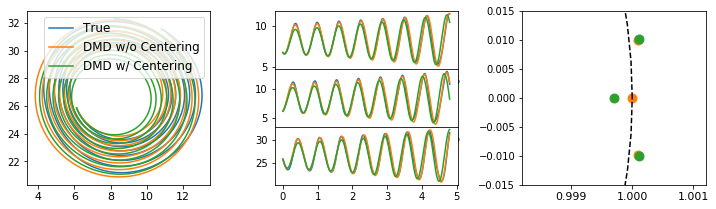

In [5]:
fig = plt.figure(figsize=(10,3))

plt.subplot2grid((3,3),(0,0),rowspan=3)
plt.plot(Y[1,:],Y[2,:],label='True')
plt.plot(normal_alg['reco'][1,:],normal_alg['reco'][2,:],label='DMD w/o Centering')
plt.plot(centered_alg['reco'][1,:],centered_alg['reco'][2,:],label='DMD w/ Centering')
#plt.xlabel('y')
#plt.ylabel('z')
plt.legend(loc=1,fontsize=12)
plt.xticks(fontsize=11)

ax = []
for _i,_title in enumerate(('x','y','z')):
    if _i==0:
        ax.append(plt.subplot2grid((3,3),(_i,1)))
    else:
        ax.append(plt.subplot2grid((3,3),(_i,1),sharex=ax[0]))
        
    #plt.subplot(3,1,_i+1)
    plt.plot(t_vals,Y[_i,:])
    plt.plot(t_vals,normal_alg['reco'][_i,:])
    plt.plot(t_vals,centered_alg['reco'][_i,:])
    #plt.ylabel(_title)
    #if _i < 2:
    #    plt.xticks([])
#plt.xlabel('t')
plt.tight_layout()
#plt.subplots_adjust(0,0,1,1)
plt.subplots_adjust(hspace=0.0,wspace=0.35)
#plt.setp(ax[2].get_xticklabels(), visible=True)
#plt.setp(ax[1].get_xticklabels(), visible=True)

plt.subplot2grid((3,3),(0,2),rowspan=3)
plt.scatter(np.real(normal_alg['eig_vals']),np.imag(normal_alg['eig_vals']),label='DMD',c=(*to_rgb('tab:orange'),1.0),
                            s=80,edgecolors=(*to_rgb('tab:orange'),1.0))


plt.scatter(np.real(centered_alg['eig_vals']),np.imag(centered_alg['eig_vals']),label='DMD with Centering',c=(*to_rgb('tab:green'),1.0),
                            s=80,edgecolors=(*to_rgb('tab:green'),1.0))
temp = np.linspace(0,1,1000)
x = np.cos(2*np.pi*temp)
y = np.sin(2*np.pi*temp)
plt.plot(x,y, 'k--')
plt.xlim([0.9982,1.0012])
plt.ylim([-.015,0.015])
plt.xticks([0.999,1.,1.001])
plt.xticks(fontsize=11)


#plt.show()
plt.savefig('../Writeup/Figures/lorenz_no_noise.png',bbox_inches='tight')